In [1]:
%load_ext autoreload
%autoreload 2

import json
import re
from pathlib import Path

import torch
import nnsight
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from transformers import AutoTokenizer
import einops

# --- Parameters ---
MODEL_NAME = "meta-llama/Llama-3.3-70B-Instruct"
DATA_FILE = Path("../data/patching_dataset_N32_mixed.jsonl") # From 100_patching_setup
MAX_NEW_TOKENS = 6 # Max length for the answer

# The heads identified in a previous experiment. We'll take the top 10.
ANALOGY_HEADS = [(33, 16), (14, 21), (27, 21), (35, 19), (34, 4), (30, 52), (39, 43), (34, 48), (33, 42), (33, 14), (35, 18), (28, 1), (34, 44), (27, 38), (49, 7), (28, 45), (35, 17), (34, 43), (27, 22), (31, 38), (31, 35), (16, 48), (20, 8), (38, 48), (32, 18), (28, 40), (29, 30), (35, 34), (30, 33), (30, 24), (24, 6), (33, 41), (2, 60), (5, 46), (27, 20), (18, 43), (33, 54), (25, 60), (37, 30), (28, 41), (38, 52), (26, 37), (32, 43), (39, 40), (49, 2), (33, 45), (31, 20), (28, 6), (24, 30), (54, 11), (31, 39), (18, 37), (8, 43), (30, 29), (28, 46), (32, 7), (15, 19), (15, 21), (17, 61), (6, 6), (4, 45), (28, 47), (30, 51), (33, 15), (21, 26), (19, 51), (22, 7), (32, 21), (33, 9), (11, 34), (16, 31), (26, 23), (31, 28), (31, 0), (12, 3), (22, 29), (1, 47), (34, 46), (24, 7), (23, 42)]
TOP_K_HEADS = 25
CANDIDATE_HEADS = ANALOGY_HEADS

print(f"Using top all heads for experiment: {CANDIDATE_HEADS}")


Using top all heads for experiment: [(33, 16), (14, 21), (27, 21), (35, 19), (34, 4), (30, 52), (39, 43), (34, 48), (33, 42), (33, 14), (35, 18), (28, 1), (34, 44), (27, 38), (49, 7), (28, 45), (35, 17), (34, 43), (27, 22), (31, 38), (31, 35), (16, 48), (20, 8), (38, 48), (32, 18), (28, 40), (29, 30), (35, 34), (30, 33), (30, 24), (24, 6), (33, 41), (2, 60), (5, 46), (27, 20), (18, 43), (33, 54), (25, 60), (37, 30), (28, 41), (38, 52), (26, 37), (32, 43), (39, 40), (49, 2), (33, 45), (31, 20), (28, 6), (24, 30), (54, 11), (31, 39), (18, 37), (8, 43), (30, 29), (28, 46), (32, 7), (15, 19), (15, 21), (17, 61), (6, 6), (4, 45), (28, 47), (30, 51), (33, 15), (21, 26), (19, 51), (22, 7), (32, 21), (33, 9), (11, 34), (16, 31), (26, 23), (31, 28), (31, 0), (12, 3), (22, 29), (1, 47), (34, 46), (24, 7), (23, 42)]


In [2]:
# Load the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True, trust_remote_code=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = nnsight.LanguageModel(
    MODEL_NAME,
    tokenizer=tokenizer,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    attn_implementation="eager"
)

# Get model dimensions
D_MODEL = model.config.hidden_size
N_HEADS = model.config.num_attention_heads
N_LAYERS = model.config.num_hidden_layers
D_HEAD = D_MODEL // N_HEADS

print("Model and tokenizer loaded.")


Model and tokenizer loaded.


In [3]:
import gc

def free_gpu_cache():
    gc.collect()
    torch.cuda.empty_cache()

free_gpu_cache()

In [4]:
# Load the frozen dataset
def read_jsonl(path):
    with open(path, 'r', encoding='utf-8') as f:
        return [json.loads(line) for line in f]

eval_items = read_jsonl(DATA_FILE)
print(f"Loaded {len(eval_items)} items from {DATA_FILE}")

# Let's look at the first example
print("\nFirst example:")
print(json.dumps(eval_items[0], indent=2))


Loaded 32 items from ../data/patching_dataset_N32_mixed.jsonl

First example:
{
  "story": "The feclur is made of placlugav. The artifact is crafted out of resin. The feclur is within the frifeslo. The artifact is within the library.",
  "analogy": "artifact is to feclur as resin is to",
  "answer": "placlugav",
  "meta": {
    "relation_target": "made of",
    "relation_distractor_family": "located in",
    "surface_r1_s1": "crafted out of",
    "surface_r1_s2": "made of",
    "surface_r2_s1": "within",
    "surface_r2_s2": "within",
    "lexicon_condition": "mixed",
    "s1_noun_type": "real",
    "s2_noun_type": "fake",
    "seed": 23,
    "template": "S1:S2::O1:?",
    "task": "Task-5 (O\u2192O across)"
  },
  "prompt_source": "Finish the analogy in one word.\nThe feclur is made of placlugav. The artifact is crafted out of resin. The feclur is within the frifeslo. The artifact is within the library.\n\nartifact is to feclur as resin is to",
  "prompt_base": "Finish the analogy in o

In [5]:
# --- Core Logic and Helper Functions ---

def canonicalize(text: str) -> str:
    """Simple string cleaning for comparing model outputs."""
    return re.sub(r"[\s'\".,;:]+$", "", text.strip().lower())

def get_em1(prompt: str, gold_answer: str, intervention_fn=None) -> int:
    """
    Runs a single forward pass and returns 1 if the top predicted next token
    is an exact match, else 0.
    """
    with model.trace(prompt, validate=False):
        # If an intervention function is provided, call it.
        if intervention_fn:
            intervention_fn()
        
        # Get the logits for the final token position.
        final_logits = model.output.logits[0, -1, :]
        
        # Get the token ID of the top prediction and save it.
        predicted_token_id = torch.argmax(final_logits).save()

    # After the trace, get the concrete value from the proxy.
    prediction_id = predicted_token_id.item()
    
    # Decode the single predicted token.
    prediction = tokenizer.decode(prediction_id, skip_special_tokens=True)
    
    return int(canonicalize(prediction) in canonicalize(gold_answer))

def necessity_ablation_intervention(heads_to_ablate: list):
    """
    This function is passed to `get_em1` to perform mean-ablation.
    It's defined here and will be called by nnsight during the forward pass.
    """
    for layer, head in heads_to_ablate:
        attn_out_proxy = model.model.layers[layer].self_attn.o_proj.input[0]
        reshaped_proxy = einops.rearrange(
            attn_out_proxy, "s (h d) -> s h d", h=N_HEADS, d=D_HEAD
        )
        head_mean = reshaped_proxy[:, head, :].mean(dim=0, keepdim=True)
        reshaped_proxy[:, head, :] = head_mean
        model.model.layers[layer].self_attn.o_proj.input[0] = einops.rearrange(
            reshaped_proxy, "s h d -> s (h d)"
        )

def sufficiency_patching_intervention(source_activations: dict, heads_to_patch: list):
    """
    This function is passed to `get_em1` to perform patching.
    It patches in the previously saved `source_activations`.
    """
    for layer, head in heads_to_patch:
        attn_out_proxy = model.model.layers[layer].self_attn.o_proj.input[0]
        reshaped_proxy = einops.rearrange(
            attn_out_proxy, "s (h d) -> s h d", h=N_HEADS, d=D_HEAD
        )
        source_head_activation = source_activations[(layer, head)]
        reshaped_proxy[:, head, :] = source_head_activation
        model.model.layers[layer].self_attn.o_proj.input[0] = einops.rearrange(
            reshaped_proxy, "s h d -> s (h d)"
        )

print("Helper functions for necessity and sufficiency experiments defined.")

Helper functions for necessity and sufficiency experiments defined.


In [6]:
# --- Experiment 1: Necessity (Targeted Ablation) ---

necessity_results = []
dataset_subset = eval_items # Using the full dataset as specified

print("Running necessity experiment (targeted ablation)...")

# Loop over each example in the dataset
for ex_idx, ex in enumerate(tqdm(dataset_subset, desc="Ablation Testing")):
    prompt = ex['prompt_source'] # For necessity, we test on the correct prompt
    print(f"{prompt=}")
    gold_answer = ex['answer']
    print(f"{gold_answer=}")
    
    # 1. Get baseline performance (no intervention)
    baseline_em1 = get_em1(prompt, gold_answer)
    print(f"{baseline_em1=}")
    
    # 2. Get performance when ablating the entire set of candidate heads
    all_ablated_em1 = get_em1(
        prompt, 
        gold_answer, 
        intervention_fn=lambda: necessity_ablation_intervention(CANDIDATE_HEADS)
    )
    print(f"{all_ablated_em1=}")
    
    # Store the result for the full set ablation
    necessity_results.append({
        "ex_idx": ex_idx,
        "head": "all_10",
        "baseline_em1": baseline_em1,
        "ablated_em1": all_ablated_em1
    })

    # 3. Get performance when ablating each head individually
    for layer, head in CANDIDATE_HEADS:
        single_head_to_ablate = [(layer, head)]
        
        # The `h=single_head_to_ablate` trick ensures the lambda captures the correct head
        single_ablated_em1 = get_em1(
            prompt, 
            gold_answer, 
            intervention_fn=lambda h=single_head_to_ablate: necessity_ablation_intervention(h)
        )
        
        necessity_results.append({
            "ex_idx": ex_idx,
            "head": f"L{layer}H{head}",
            "baseline_em1": baseline_em1,
            "ablated_em1": single_ablated_em1
        })

print("Necessity experiment complete.")

# Convert to a DataFrame for easier analysis
df_necessity = pd.DataFrame(necessity_results)

Running necessity experiment (targeted ablation)...


Ablation Testing:   0%|          | 0/32 [00:00<?, ?it/s]

prompt='Finish the analogy in one word.\nThe feclur is made of placlugav. The artifact is crafted out of resin. The feclur is within the frifeslo. The artifact is within the library.\n\nartifact is to feclur as resin is to'
gold_answer='placlugav'


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

baseline_em1=1
all_ablated_em1=1
prompt='Finish the analogy in one word.\nThe caceli is crafted out of nislof. The caceli is housed in the zatradre. The vase is situated in the school. The vase is constructed from marble.\n\ncaceli is to vase as nislof is to'
gold_answer='marble'
baseline_em1=1
all_ablated_em1=0
prompt='Finish the analogy in one word.\nThe enitocod is inside the ehugori. The bottle is composed of oak. The bottle is housed in the school. The enitocod is made of prikucr.\n\nenitocod is to bottle as prikucr is to'
gold_answer='oak'
baseline_em1=1
all_ablated_em1=0
prompt='Finish the analogy in one word.\nThe flispu is situated in the uzath. The vase is composed of glass. The flispu is constructed from oyicez. The vase is inside the mall.\n\nvase is to flispu as glass is to'
gold_answer='oyicez'
baseline_em1=0
all_ablated_em1=0
prompt='Finish the analogy in one word.\nThe ubiskey is located in the grutre. The ubiskey is made of ploralel. The jar is constructed from oak. Th

Baseline EM@1 Accuracy: 0.688
After ablating top 25 heads: 0.250
Accuracy Drop: 0.438 (63.6%)


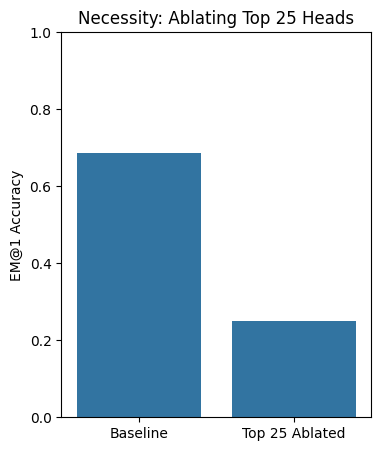

In [7]:
# --- Analysis and Visualization ---

# 1. Overall Effect of Ablating the Full Set
df_all_ablated = df_necessity[df_necessity['head'] == 'all_10']
baseline_acc = df_all_ablated['baseline_em1'].mean()
full_ablation_acc = df_all_ablated['ablated_em1'].mean()
acc_drop = baseline_acc - full_ablation_acc

print(f"Baseline EM@1 Accuracy: {baseline_acc:.3f}")
print(f"After ablating top {TOP_K_HEADS} heads: {full_ablation_acc:.3f}")
print(f"Accuracy Drop: {acc_drop:.3f} ({(acc_drop / baseline_acc) * 100:.1f}%)")

# Plot: Baseline vs. Ablated Set
plt.figure(figsize=(4, 5))
sns.barplot(x=['Baseline', f'Top {TOP_K_HEADS} Ablated'], y=[baseline_acc, full_ablation_acc])
plt.title(f'Necessity: Ablating Top {TOP_K_HEADS} Heads')
plt.ylabel('EM@1 Accuracy')
plt.ylim(0, 1)
plt.show()

# # 2. Per-Head Ablation Effect
# df_single_heads = df_necessity[df_necessity['head'] != 'all_10'].copy()
# df_single_heads['em1_drop'] = df_single_heads['baseline_em1'] - df_single_heads['ablated_em1']
# mean_drop_per_head = df_single_heads.groupby('head')['em1_drop'].mean().sort_values(ascending=False)
# 
# # Plot: Per-head delta EM@1
# plt.figure(figsize=(10, 6))
# mean_drop_per_head.plot(kind='bar')
# plt.title('Individual Head Ablation: Mean Drop in EM@1')
# plt.ylabel('Δ EM@1 (Drop in Accuracy)')
# plt.xlabel('Head (Layer, Index)')
# plt.xticks(rotation=45, ha='right')
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()
# 
# # 3. Cumulative Ablation Curve
# # Note: This part re-runs the experiment and can be slow.
# cumulative_results = []
# sorted_heads = mean_drop_per_head.index.tolist()
# 
# for k in range(1, len(sorted_heads) + 1):
#     heads_to_ablate_k = [(int(h.split('H')[0][1:]), int(h.split('H')[1])) for h in sorted_heads[:k]]
#     
#     ablated_scores = []
#     for ex in tqdm(eval_items, desc=f'Cumulative Ablating Top {k}', leave=False):
#         score = get_em1(
#             ex['prompt_source'], 
#             ex['answer'], 
#             intervention_fn=lambda h=heads_to_ablate_k: necessity_ablation_intervention(h)
#         )
#         ablated_scores.append(score)
#     
#     cumulative_results.append({'k': k, 'em1': np.mean(ablated_scores)})
# 
# df_cumulative = pd.DataFrame(cumulative_results)
# 
# # Plot: Cumulative Ablation
# plt.figure(figsize=(8, 5))
# plt.plot(df_cumulative['k'], df_cumulative['em1'], marker='o', linestyle='-')
# plt.axhline(y=baseline_acc, color='r', linestyle='--', label=f'Baseline Acc ({baseline_acc:.3f})')
# plt.axhline(y=full_ablation_acc, color='g', linestyle='--', label=f'Full Ablation Acc ({full_ablation_acc:.3f})')
# plt.title('Cumulative Ablation of Top Heads')
# plt.xlabel('Number of Top Heads Ablated (k)')
# plt.ylabel('EM@1 Accuracy')
# plt.xticks(range(1, len(sorted_heads) + 1))
# plt.legend()
# plt.grid(True, which='both', linestyle='--', alpha=0.7)
# plt.ylim(0, 1)
# plt.show()
# 
# # 4. Sufficiency Results
# base_acc_sufficiency = df_sufficiency['base_em1'].mean()
# patched_acc_sufficiency = df_sufficiency['patched_em1'].mean()
# acc_recovery = patched_acc_sufficiency - base_acc_sufficiency
# 
# print("\n--- Sufficiency Experiment Results ---")
# print(f"Base (Corrupted) Prompt EM@1: {base_acc_sufficiency:.3f}")
# print(f"After patching top 10 heads: {patched_acc_sufficiency:.3f}")
# print(f"Accuracy Recovery: +{acc_recovery:.3f}")